In [20]:
# Torch
import torch
from torch_geometric.data import DataLoader
from torch_geometric.loader import DataLoader

from torch_geometric.nn import SAGEConv, DenseSAGEConv, GATConv, HeteroConv, Linear
from torch_geometric.nn import aggr

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Scikit-learn
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc, brier_score_loss

# Misc
import os
import time
from math import ceil
import random
from IPython.display import clear_output
from termcolor import colored


# Torch and CUDA options
torch.manual_seed(42)
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Path constants
PATH_GRAPH_DATA = '../../data/matches-processed/cs2/hetero-graph/'
PATH_MODELS = '../../model/gnn/'

## Data Loaders

In [3]:
BATCH_SIZE = 500


def print_ct_win_percentage(dataset):
    ct_wins = 0
    for data in dataset:
        ct_wins += data.y['CT_wins']

    print('CT wins %:', ct_wins / len(dataset))

### Training data

In [4]:
train_data = torch.load(PATH_GRAPH_DATA + 'train.pt', weights_only=False)

random.shuffle(train_data)
if len(train_data) % BATCH_SIZE != 0:
    train_data = train_data[:-(len(train_data) % BATCH_SIZE)]

print('Train data length:', len(train_data))
print_ct_win_percentage(train_data)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

Train data length: 7000
CT wins %: 0.33585714285714285


In [5]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

### Validation data

In [9]:
val_data = torch.load(PATH_GRAPH_DATA + 'val.pt', weights_only=False)

random.shuffle(val_data)
if len(val_data) % BATCH_SIZE != 0:
    val_data = val_data[:-(len(val_data) % BATCH_SIZE)]

print('Validation data length:', len(val_data))
print_ct_win_percentage(val_data)

val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

Validation data length: 8000
CT wins %: 0.58125


In [10]:
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

----
## Heterogeneous GNN

In this section, the heterogeneous GNN model is defined as well as the essentials for the training process, including data loaders, loss metrics, optimizer, the training / validation / test functions along with the plotting one to make interpretation easy.

In [14]:
class HeterogeneousGNN(torch.nn.Module):

    # --------------------------------------------------
    # Initialization
    # --------------------------------------------------

    def __init__(self, player_dims, map_dims, dense_layers):

        super().__init__()

        self.conv_layer_number = max([len(player_dims), len(map_dims)])
        self.player_convs = len(player_dims)
        self.map_convs = len(map_dims)

        # Create convolutional layers
        self.convs = torch.nn.ModuleList()
        for conv_idx in range(self.conv_layer_number):

            layer_config = {}

            if conv_idx < len(player_dims):
                layer_config[('player', 'is', 'player')] = GATConv((-1, -1), player_dims[conv_idx], add_self_loops=False)

            if conv_idx < len(player_dims):
                layer_config[('player', 'closest_to', 'map')] = GATConv((-1, -1), map_dims[conv_idx], add_self_loops=False)

            if conv_idx < len(map_dims):
                layer_config[('map', 'connected_to', 'map')] = GATConv((-1, -1), map_dims[conv_idx], add_self_loops=False)

            conv = HeteroConv(layer_config, aggr='mean')
            self.convs.append(conv)



        # Create linear layer for the flattened input
        self.linear = Linear(-1, dense_layers[0]['input_neuron_num'])

        
        # Create dense layers based on the 'dense_layers' parameter
        dense_layers_container = []
        for layer_config in dense_layers:

            if layer_config['dropout'] == 0:
                # Add the first layer manually because it has a different input size
                dense_layers_container.append(torch.nn.Linear(layer_config['input_neuron_num'], layer_config['neuron_num']))
                
                # Add activation function if it is not None - the last layer does not have sigmoid activation function because of the BCEWithLogitsLoss
                if layer_config['activation_function'] is not None:
                    dense_layers_container.append(layer_config['activation_function'])

                # Add the rest of the layers (if there are any)
                for _ in range(layer_config['num_of_layers'] - 1):
                    dense_layers_container.append(torch.nn.Linear(layer_config['neuron_num'], layer_config['neuron_num']))

                    # Add activation function if it is not None - the last layer does not have sigmoid activation function because of the BCEWithLogitsLoss
                    if layer_config['activation_function'] is not None:
                        dense_layers_container.append(layer_config['activation_function'])
            else:
                dense_layers_container.append(torch.nn.Dropout(layer_config['dropout']))
        
        self.dense = torch.nn.Sequential(*dense_layers_container)
        





    # --------------------------------------------------
    # Forward pass
    # --------------------------------------------------

    def forward(self, x_dict, edge_index_dict, y, batch_size):

        # Do the convolutions
        conv_idx = 1
        for conv in self.convs:
            temp = conv(x_dict, edge_index_dict)
            
            if conv_idx < self.player_convs:
                x_dict['player'] = temp['player']

            if conv_idx < self.map_convs:
                x_dict['map'] = temp['map']
                
            x_dict = {key: torch.nn.functional.leaky_relu(x) for key, x in x_dict.items()}

            conv_idx += 1


        # Container for the flattened graphs after the convolutions
        flattened_graphs = []

        # Do the convolutions for each graph in the batch
        for graph_idx in range(batch_size):

            # Get the actual graph
            actual_x_dict, actual_edge_index_dict = self.get_actual_graph(x_dict, edge_index_dict, graph_idx, batch_size)

            # Get the graph data
            graph_data = torch.tensor([
                y['round'][graph_idx],
                y['time'][graph_idx],
                y['remaining_time'][graph_idx],
                y['CT_alive_num'][graph_idx],
                y['T_alive_num'][graph_idx],
                y['CT_total_hp'][graph_idx],
                y['T_total_hp'][graph_idx],
                y['CT_equipment_value'][graph_idx],
                y['T_equipment_value'][graph_idx],
                y['CT_losing_streak'][graph_idx],
                y['T_losing_streak'][graph_idx],
                y['is_bomb_dropped'][graph_idx],
                y['is_bomb_being_planted'][graph_idx],
                y['is_bomb_being_defused'][graph_idx],
                y['is_bomb_planted_at_A_site'][graph_idx],
                y['is_bomb_planted_at_B_site'][graph_idx],
                y['bomb_X'][graph_idx],
                y['bomb_Y'][graph_idx],
                y['bomb_Z'][graph_idx],
                y['bomb_mx_pos1'][graph_idx],
                y['bomb_mx_pos2'][graph_idx],
                y['bomb_mx_pos3'][graph_idx],
                y['bomb_mx_pos4'][graph_idx],
                y['bomb_mx_pos5'][graph_idx],
                y['bomb_mx_pos6'][graph_idx],
                y['bomb_mx_pos7'][graph_idx],
                y['bomb_mx_pos8'][graph_idx],
                y['bomb_mx_pos9'][graph_idx],
            ]).to('cuda')

            # Create the flattened input tensor and append it to the container
            x = torch.cat([torch.flatten(actual_x_dict['player']), torch.flatten(actual_x_dict['map']), torch.flatten(graph_data)])

            flattened_graphs.append(x)

        # Stack the flattened graphs
        x = torch.stack(flattened_graphs).to('cuda')

        x = self.linear(x)
        x = torch.nn.functional.leaky_relu(x)
        
        x = self.dense(x)
        
        return x
    






    # --------------------------------------------------
    # Helper functions
    # --------------------------------------------------

    def get_actual_graph(self, x_dict, edge_index_dict, graph_idx, batch_size):

        # Node feature dictionary for the actual graph
        actual_x_dict = {}

        single_player_node_size = int(x_dict['player'].shape[0] / batch_size)
        single_map_node_size = int(x_dict['map'].shape[0] / batch_size)

        actual_x_dict['player'] = x_dict['player'][graph_idx*single_player_node_size:(graph_idx+1)*single_player_node_size, :]
        actual_x_dict['map'] = x_dict['map'][graph_idx*single_map_node_size:(graph_idx+1)*single_map_node_size, :]


        # Edge index dictionary for the actual graph
        actual_edge_index_dict = {}

        single_map_to_map_edge_size = int(edge_index_dict[('map', 'connected_to', 'map')].shape[1] / batch_size)
        single_player_to_map_edge_size = int(edge_index_dict[('player', 'closest_to', 'map')].shape[1] / batch_size)

        actual_edge_index_dict[('map', 'connected_to', 'map')] = edge_index_dict[('map', 'connected_to', 'map')] \
            [:, graph_idx*single_map_to_map_edge_size:(graph_idx+1)*single_map_to_map_edge_size] \
            - graph_idx*single_map_node_size
        
        actual_edge_index_dict[('player', 'closest_to', 'map')] = edge_index_dict[('player', 'closest_to', 'map')] \
            [:, graph_idx*single_player_to_map_edge_size:(graph_idx+1)*single_player_to_map_edge_size]
        
        actual_edge_index_dict_correction_tensor = torch.tensor([single_player_node_size*graph_idx, single_map_node_size*graph_idx]).to('cuda')
        actual_edge_index_dict[('player', 'closest_to', 'map')] = actual_edge_index_dict[('player', 'closest_to', 'map')] - actual_edge_index_dict_correction_tensor.view(-1, 1)

        
        return actual_x_dict, actual_edge_index_dict
    


In [63]:
def train(model, optimizer, loss_function, train_loader, val_loaders, batch_size, epochs, trainable_params, save_path):

    torch.cuda.empty_cache()

    train_losses = []
    val_losses = []
    accuracies = []
    brier_scores = []
    precisions = []
    recalls = []
    f1_scores = []

    for epoch in range(1, epochs + 1):

        epoch_start = time.time()
        model.train()

        total_loss = 0

        for data in train_loader:  # Iterate in batches over the training dataset.

            data = data.to('cuda')
            optimizer.zero_grad()  # Clear gradients.
            
            out = model(data.x_dict, data.edge_index_dict, data.y, batch_size).float()  # Perform a single forward pass.
            target = torch.tensor(data.y['CT_wins']).float().to('cuda') 

            loss = loss_function(out.squeeze(), target)  # Compute the loss.
            loss.backward()  # Backpropagate.
            optimizer.step()  # Update model parameters.

            total_loss += loss.item()  # Accumulate the loss.


        # Calculate train and validation metrics
        train_avg_loss = total_loss / len(train_loader)
        val_avg_loss, val_accuracy, val_brier_score, val_precision, val_recall, val_f1, val_conf_mx, val_fpr, val_tpr, val_sorted_predictions = validation(model, loss_function, val_loaders, batch_size) 

        # Epoch information
        epoch_end = time.time()
        epoch_duration = epoch_end - epoch_start
        epoch_end_time = time.asctime(time.localtime()) 

        # Save metrics
        train_losses.append(train_avg_loss)
        val_losses.append(val_avg_loss)
        accuracies.append(val_accuracy)
        brier_scores.append(val_brier_score)
        precisions.append(val_precision)
        recalls.append(val_recall)
        f1_scores.append(val_f1)


        # Save model
        torch.save(model, PATH_MODELS + save_path + f'epoch_{epoch}.pt')

        # Visualize epoch
        epoch_result_visualization(
            epochs, 
            epoch,
            epoch_end_time,
            epoch_duration,

            train_losses, 
            val_losses, 
            accuracies,
            brier_scores,
            precisions, 
            recalls, 
            f1_scores,
            val_conf_mx,
            val_fpr, val_tpr,
            val_sorted_predictions,

            trainable_params,
            save_path
        )

        

def validation(model, loss_function, val_loader, batch_size):
    
    # Switch to evaluation mode.
    model.eval()

    total_loss = 0

    predictions_all = []
    targets_all = []

    with torch.no_grad():
        
        for data in val_loader:  # Iterate in batches over the validation dataset.
            data = data.to('cuda')

            out = model(data.x_dict, data.edge_index_dict, data.y, batch_size).float()
            target = torch.tensor(data.y['CT_wins']).float().to('cuda')

            loss = loss_function(out.squeeze(), target)
            total_loss += loss.item()

            # Get the predictions
            predictions = torch.sigmoid(out).float()

            predictions_all.extend(predictions.cpu().numpy())
            targets_all.extend(target.cpu().numpy())

    # Prediction formattings
    predictions_all = np.array(predictions_all).flatten().tolist()
    sorted_predictions = np.sort(predictions_all).tolist()
    rounded_predictions = np.round(predictions_all)

    # Calculate metrics
    val_avg_loss = total_loss / len(val_loader)
    accuracy = accuracy_score(targets_all, rounded_predictions)
    brier_score = brier_score_loss(targets_all, predictions_all)
    precision = precision_score(targets_all, rounded_predictions)
    recall = recall_score(targets_all, rounded_predictions)
    f1 = f1_score(targets_all, rounded_predictions)
    cm = confusion_matrix(targets_all, rounded_predictions)
    fpr, tpr, _ = roc_curve(targets_all, predictions_all)

    return val_avg_loss, accuracy, brier_score, precision, recall, f1, cm, fpr, tpr, sorted_predictions



def epoch_result_visualization(
    epochs,
    epoch,
    epoch_end_time,
    epoch_duration,

    train_losses,
    val_losses,
    accuracies, 
    brier_scores,
    precisions, 
    recalls, 
    f1_scores,
    conf_mx,
    fpr, tpr,
    sorted_predictions,

    trainable_params,
    save_path
):
    # Clear the output
    clear_output(wait=True)

    # Print the results
    print_epoch_results(epoch, epoch_end_time, epoch_duration, train_losses[-1], val_losses[-1], accuracies[-1], brier_scores[-1], precisions[-1], recalls[-1], f1_scores[-1], trainable_params, save_path)
    
    
    # Visualize the confusion matrix, ROC/AUC curve and model calibration plot
    visualize_CM_ROCAUC_CAL(conf_mx, fpr, tpr, sorted_predictions, save_path, epoch)


    # Visualize the training and validation loss
    visualize_train_val_metrics(epochs, epoch, train_losses, val_losses, accuracies, brier_scores, precisions, recalls, f1_scores, save_path)

def print_epoch_results(epoch, epoch_end_time, epoch_duration, train_avg_loss, val_avg_loss, accuracy, brier_score, precision, recall, f1, trainable_params, save_path):

    print('Trainable parameters: ' + str(trainable_params))
    print("-------------------------------------------------------------------------------------------\n"
         f"                                     Epoch {epoch}\n"
          "-------------------------------------------------------------------------------------------\n" + 
          colored('Time: \n', "light_blue", attrs=["bold"]) +
         f"   -End time: {epoch_end_time}s \n"
         f"   -Duration: {epoch_duration}s \n"
          ". . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .\n" +
          colored('Training results: \n', "light_blue", attrs=["bold"]) +
         f"   - Average loss: {train_avg_loss:.4f} \n"
          ". . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .\n" +
          colored('Validation results: \n', "light_blue", attrs=["bold"]) +
         f"   - Average loss: {val_avg_loss} \n"
         f"   - Accuracy: {accuracy} \n"
         f"   - Brier score: {brier_score} \n"
         f"   - Precision: {precision} \n"
         f"   - Recall: {recall} \n"
         f"   - F1: {f1} \n"
          ". . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .\n")
    
    with open(PATH_MODELS + save_path + f'epoch_{epoch}_metrics.txt', 'w') as file:
        file.write(
          "Trainable parameters: " + str(trainable_params) + "\n"
          "-------------------------------------------------------------------------------------------\n"
         f"                                     Epoch {epoch}\n"
          "-------------------------------------------------------------------------------------------\n"
          "Time: \n"
         f"   -End time: {epoch_end_time}s \n"
         f"   -Duration: {epoch_duration}s \n"
          ". . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .\n"
          "Training results:\n"
         f"   - Average loss: {train_avg_loss:.4f} \n"
          ". . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .\n"
          "Validation results: \n"
         f"   - Average loss: {val_avg_loss} \n"
         f"   - Accuracy: {accuracy} \n"
         f"   - Brier score: {brier_score} \n"
         f"   - Precision: {precision} \n"
         f"   - Recall: {recall} \n"
         f"   - F1: {f1} \n"
          ". . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .\n")

def visualize_CM_ROCAUC_CAL(cm, fpr, tpr, sorted_predictions, save_path, epoch):

    fig, axs = plt.subplots(1, 3, figsize=(8, 3))
    fig.suptitle(f'Epoch {epoch} - Validation scores', fontsize=12)


    # Confusion Matrix
    im = axs[0].matshow(cm, cmap='Blues', alpha=0.6)
    axs[0].set_aspect('equal')
    axs[0].set_title('Confusion matrix', fontsize=10, y=1)
    axs[0].set_xlabel('Predicted', fontsize=8)
    axs[0].set_ylabel('Actual', fontsize=8)
    # Add numbers to the confusion matrix
    for (i, j), val in np.ndenumerate(cm):
        axs[0].text(j, i, f'{val}', ha='center', va='center', fontsize=10, color='black')
    # Set x-ticks to bottom
    axs[0].set_xticks([0, 1])
    axs[0].set_xticklabels([0, 1])
    axs[0].tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False)


    # ROC/AUC Curve
    axs[1].plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f' % auc(fpr, tpr))
    axs[1].plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    axs[1].set_xlim([0.0, 1.0])
    axs[1].set_ylim([0.0, 1.05])
    axs[1].set_xlabel('False Positive Rate', fontsize=8)
    axs[1].set_ylabel('True Positive Rate', fontsize=8)
    axs[1].set_title('ROC/AUC Curve', fontsize=10, y=1)
    axs[1].legend(loc="lower right", fontsize=8)
    axs[1].set_aspect('equal')

    # Model calibration plot
    axs[2].plot(np.linspace(1, len(sorted_predictions), len(sorted_predictions)), sorted_predictions, lw=2)
    axs[2].set_ylim([0.0, 1.0])
    axs[2].plot([0, len(sorted_predictions)], [0, 1], color='black', lw=1, linestyle='--')
    axs[2].set_xlabel('Samples', fontsize=8)
    axs[2].set_ylabel('Predicted Proba', fontsize=8)
    axs[2].set_title('Calibration curve', fontsize=10, y=1)
    axs[2].set_aspect('auto')

    plt.tight_layout()
    plt.savefig(PATH_MODELS + save_path + f'epoch_{epoch}_val_conf_AUC_cal.png')
    plt.show()

def visualize_train_val_metrics(epochs, epoch, train_losses, val_losses, accuracies, brier_scores, precisions, recalls, f1_scores, save_path):

    # ----------------------------------------
    # Metrics visualization
    # ----------------------------------------

    fig, axs = plt.subplots(2, 4, figsize=(11, 4.5))
    fig.suptitle('Training and Validation Metrics Over Epochs', fontsize=12)

    epochs_range = np.arange(1, epoch + 1)

    def plot_metric(ax, data, title, ylabel, color):
        if len(data) == 1:
            ax.scatter(epochs_range, data, s=10, c=color)
        else:
            ax.plot(epochs_range, data, marker='o', linestyle='-', color=color)
        ax.set_title(title, fontsize=10)
        ax.set_xlabel('Epoch', fontsize=8)
        ax.set_ylabel(ylabel, fontsize=8)
        ax.set_xticks(epochs_range)
        ax.set_xlim(-1, epochs)
        if 'Loss' not in title:
            ax.set_ylim(0, 1)
        ax.grid(True)

    plot_metric(axs[0, 0], train_losses, 'Train Loss', 'Loss', 'cornflowerblue')
    plot_metric(axs[0, 1], val_losses, 'Validation Loss', 'Loss', 'darkorange')
    plot_metric(axs[0, 2], accuracies, 'Accuracy', 'Accuracy', 'limegreen')
    plot_metric(axs[0, 3], brier_scores, 'Brier score', 'Brier score', 'slateblue')
    plot_metric(axs[1, 0], precisions, 'Precision', 'Precision', 'red')
    plot_metric(axs[1, 1], recalls, 'Recall', 'Recall', 'teal')
    plot_metric(axs[1, 2], f1_scores, 'F1 Score', 'F1 Score', 'black')

    plt.tight_layout()
    plt.savefig(PATH_MODELS + save_path + f'epoch_{epoch}_val_metrics.png')
    plt.show()



# TODO: rewrite according to updated train and validation functions
def test(model, loss_function, test_loader, batch_size):
    model.eval()  # Switch to evaluation mode.
    total_loss = 0
    total_samples = 0
    predictions_all = []
    targets_all = []

    with torch.no_grad():
        for data in test_loader:  # Iterate in batches over the test dataset.
            data = data.to('cuda')

            out = model(data.x_dict, data.edge_index_dict, data.y, batch_size).float()
            target = torch.tensor(data.y['CT_wins']).float().to('cuda')

            loss = loss_function(out.squeeze(), target)
            total_loss += loss.item()
            total_samples += len(target)

            # Get the predictions
            predictions = torch.sigmoid(out).float()

            predictions_all.extend(predictions.cpu().numpy())
            targets_all.extend(target.cpu().numpy())

    # Calculate performance metrics
    rounded_predictions = np.round(predictions_all)
    
    sorted_predictions = [pred[0] for pred in predictions_all]
    sorted_predictions = np.sort(sorted_predictions)

    avg_loss = total_loss / len(test_loader)
    accuracy = accuracy_score(targets_all, rounded_predictions)
    precision = precision_score(targets_all, rounded_predictions)
    recall = recall_score(targets_all, rounded_predictions)
    f1 = f1_score(targets_all, rounded_predictions)
    cm = confusion_matrix(targets_all, rounded_predictions)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fpr, tpr, _ = roc_curve(targets_all, predictions_all)

    print("-------------------------------------------------------------------------------------------\n"
          "                                      Test Results\n"                                     
          "-------------------------------------------------------------------------------------------\n"
         f"Average loss: {avg_loss} \n"
         f"Accuracy: {accuracy} \n"
         f"Precision: {precision} \n"
         f"Recall: {recall} \n"
         f"F1: {f1} \n"
          "Confusion matrix & ROC/AUC\n"
          ". . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .\n")

    # ----------------------------------------
    # Confusion matrix & ROC/AUC visualization
    # ----------------------------------------

    fig, axs = plt.subplots(1, 3, figsize=(8, 3))
    fig.suptitle('Test results', fontsize=12)


    # Confusion Matrix
    im = axs[0].matshow(cm, cmap='Blues', alpha=0.6)
    axs[0].set_aspect('equal')
    axs[0].set_title('Confusion matrix', fontsize=10, y=1)
    axs[0].set_xlabel('Predicted', fontsize=8)
    axs[0].set_ylabel('Actual', fontsize=8)
    # Add numbers to the confusion matrix
    for (i, j), val in np.ndenumerate(cm):
        axs[0].text(j, i, f'{val}', ha='center', va='center', fontsize=10, color='black')
    # Set x-ticks to bottom
    axs[0].set_xticks([0, 1])
    axs[0].set_xticklabels([0, 1])
    axs[0].tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False)


    # ROC/AUC Curve
    axs[1].plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f' % auc(fpr, tpr))
    axs[1].plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    axs[1].set_xlim([0.0, 1.0])
    axs[1].set_ylim([0.0, 1.05])
    axs[1].set_xlabel('False Positive Rate', fontsize=8)
    axs[1].set_ylabel('True Positive Rate', fontsize=8)
    axs[1].set_title('ROC/AUC Curve', fontsize=10, y=1)
    axs[1].legend(loc="lower right", fontsize=8)
    axs[1].set_aspect('equal')

    # Model calibration plot
    axs[2].plot(np.linspace(1, len(sorted_predictions), len(sorted_predictions)), sorted_predictions, lw=2)
    axs[2].set_ylim([0.0, 1.0])
    axs[2].plot([0, len(sorted_predictions)], [0, 1], color='black', lw=1, linestyle='--')
    axs[2].set_xlabel('Samples', fontsize=8)
    axs[2].set_ylabel('Predicted Proba', fontsize=8)
    axs[2].set_title('Calibration curve', fontsize=10, y=1)
    axs[2].set_aspect('auto')



    plt.tight_layout()
    plt.show()

Trainable parameters: 91217
-------------------------------------------------------------------------------------------
                                     Epoch 8
-------------------------------------------------------------------------------------------
Time: 
   -End time: Sun Sep 29 13:11:33 2024s 
   -Duration: 8.454618453979492s 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Training results: 
   - Average loss: 0.3569 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Validation results: 
   - Average loss: 0.6842068508267403 
   - Accuracy: 0.65325 
   - Brier score: 0.24338123281581966 
   - Precision: 0.8879239040529363 
   - Recall: 0.4617204301075269 
   - F1: 0.6075268817204301 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .



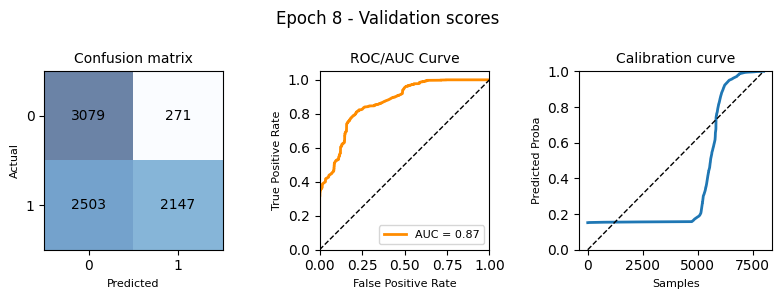

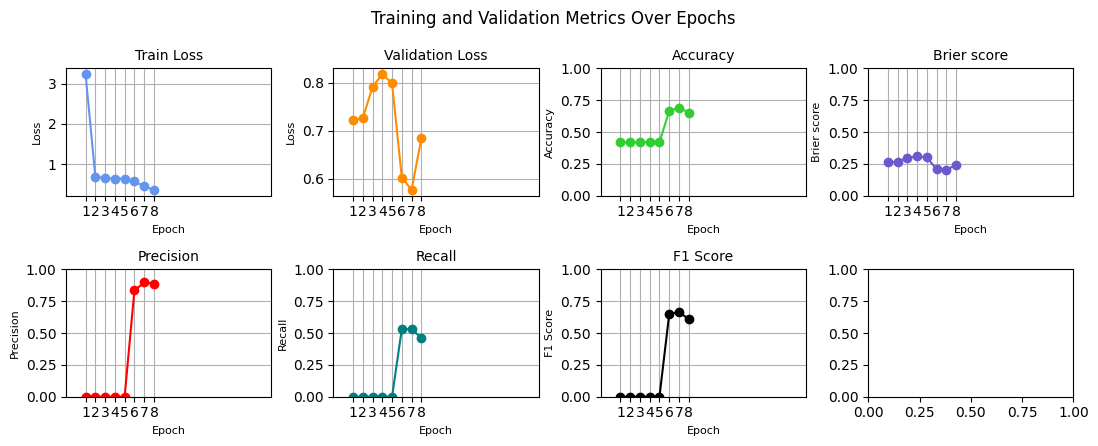

KeyboardInterrupt: 

In [64]:
dense_layers = [
    {
        "dropout": 0,
        "num_of_layers": 1,
        "neuron_num": 32,
        "input_neuron_num": 64,
        "activation_function": torch.nn.LeakyReLU()
    },
    {
        "dropout": 0.5,
    },
    {
        "dropout": 0,
        "num_of_layers": 1,
        "neuron_num": 4,
        "input_neuron_num": 32,
        "activation_function": torch.nn.LeakyReLU()
    },
    {
        "dropout": 0.2,
    },
    {
        "dropout": 0,
        "num_of_layers": 1,
        "neuron_num": 1,
        "input_neuron_num": 4,
        "activation_function": None
    },
]
save_path = 'test/'

model = HeterogeneousGNN(player_dims=[20, 5], map_dims=[15, 10, 5, 5, 3], dense_layers=dense_layers).to('cuda')
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-2, weight_decay=0.05)
loss_function = torch.nn.BCEWithLogitsLoss()

# Initialization
with torch.no_grad():
    for batch in train_loader:
        batch = batch.to('cuda')
        out = model(batch.x_dict, batch.edge_index_dict, batch.y, BATCH_SIZE)
        break
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

train(model, optimizer, loss_function, train_loader, val_loader, BATCH_SIZE, 20, trainable_params, save_path)